#  Evaluation of the Nearest Neighbor Method

In [1]:
import numpy as np
import sklearn.decomposition as decomp
import matplotlib.pyplot as plt

## Prepare data

In [9]:
data = np.char.encode(np.loadtxt("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/learningML/digits.text", dtype=str), "ascii") # Read data as array of ASCII strings
data = (data.view("S1") == b'1').astype(np.int8).reshape((-1, 32, 32)) # Convert strings into 8-bit integer arrays
y = np.repeat(np.array([0,1,8]).reshape((-1,1)), 50, axis=-1).reshape(-1) # Array of 50 "0", 50 "1"s and 50 "8"s
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]


## (a) NN with LOO-CV

**Tip 1:**
Note that NN has similarities to the $k$-means clustering algorithm, so you can adapt the implementation from the intro exercise.

**Tip 2:**
Since the features of the images are binary (a pixel is either black or white), you can use the so-called [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance), instead of the Euclidean distance for this exercise.

In [12]:
def pairwise_hamming_dist(X, Y):
  return np.sum(X[:,None,:] != Y[None,:,:], axis=-1)

max_dist = 1024*2+1

def nn_loo_cv(data, y, pairwise_distance, max_dist=max_dist):
  distance_matrix = pairwise_distance(data, data)
  np.fill_diagonal(distance_matrix, max_dist)
  nearest_neighbors = np.argmin(distance_matrix, axis=-1)
  y_pred = y[nearest_neighbors]
  return y_pred, nearest_neighbors

def plot_images(data, ys, confused_data, confused_y):
  fig, axs = plt.subplots(ncols=len(data), nrows=2)
  for i, (img, y, confused_img, confused_y) in enumerate(zip(data, ys, confused_data, confused_y)):
    ax1 = axs[0, i]
    ax2 = axs[1, i]
    ax1.imshow(img)
    ax1.axis("off")
    ax1.title.set_text(f"True: {y}")
    ax2.title.set_text(f"Assigned: {confused_y}")
    ax2.imshow(confused_img)
    ax2.axis("off")
    
  plt.show()

pred_y, nns = nn_loo_cv(data.reshape(data.shape[0], -1), y, pairwise_hamming_dist)
errors = pred_y != y
print(f"NN with LOO-CV classifies the following {np.sum(errors)} images incorrectly:")
plot_images(data[errors], y[errors], data[nns[errors]], pred_y[errors])



## (b) NN with LOO-CV using High-level Feature Embeddings

Approach 1: NN with LOO-CV and an overall density + central density embedding classifies 31 images incorrectly.
Approach 2: NN with LOO-CV and a horizontal + vertical symmetry embedding classifies 79 images incorrectly.
Approach 3: NN with LOO-CV and a Principal Component Analysis embedding classifies the following 4 images incorrectly:


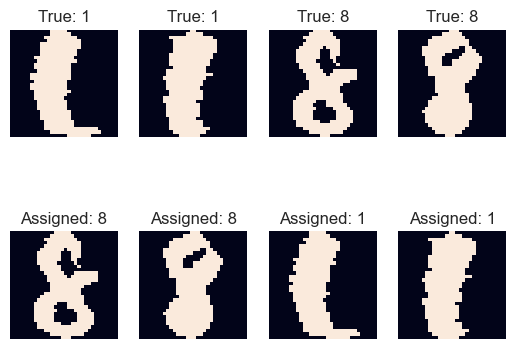

In [5]:
def pairwise_squared_dist(X, Y):
  return np.sum((X[:,None,:] - Y[None,:,:]) ** 2, axis=-1)

def compute_density(data, mask=None):
  data = data.reshape((data.shape[0], -1))
  if mask is None:
    norm = data.shape[1]
  else:
    mask = mask.reshape(1, -1)
    norm = np.sum(mask)
    data = data * mask
  return np.sum(data, axis=-1) / norm

def central_mask(shape=(32,32), center=(10,6)):
  mask = np.zeros(shape, dtype=np.int8)
  start0 = (shape[0]-center[0])//2
  start1 = (shape[1]-center[1])//2
  mask[start0:start0+center[0], start1:start1+center[1]] = 1
  return mask

def compute_symmetries(data):
  half_width = data.shape[1] // 2
  half_height = data.shape[2] // 2
  data_left = data[:, :, :half_width]
  data_right = data[:, :, :half_width-1:-1]
  data_top = data[:, :half_height, :]
  data_bottom = data[:, :half_height-1:-1, :]
  horizontal_symm = np.mean((data_left == data_right), axis=(1,2))
  vertical_symm = np.mean((data_top == data_bottom), axis=(1,2))
  return horizontal_symm, vertical_symm

def density_embed(data):
  f1 = compute_density(data)
  f2 = compute_density(data, central_mask())
  return np.stack([f1, f2], axis=1)

def symmetry_embed(data):
  f1, f2 = compute_symmetries(data)
  return np.stack([f1, f2], axis=1)

def pca_embed(data):
  pca = decomp.PCA(n_components=2)
  return pca.fit_transform(data.reshape(data.shape[0], -1))


density_data = density_embed(data)
pred_y, nns = nn_loo_cv(density_data, y, pairwise_squared_dist)
print(f"Approach 1: NN with LOO-CV and an overall density + central density embedding classifies {np.sum(pred_y != y)} images incorrectly.")

symmetry_data = symmetry_embed(data)
pred_y, nns = nn_loo_cv(symmetry_data, y, pairwise_squared_dist)
print(f"Approach 2: NN with LOO-CV and a horizontal + vertical symmetry embedding classifies {np.sum(pred_y != y)} images incorrectly.")

pca_data = pca_embed(data)
pred_y, nns = nn_loo_cv(pca_data, y, pairwise_squared_dist)
errors = pred_y != y
print(f"Approach 3: NN with LOO-CV and a Principal Component Analysis embedding classifies the following {np.sum(errors)} images incorrectly:")
plot_images(data[errors], y[errors], data[nns[errors]], pred_y[errors])

## (c) Scatter plots of the image embeddings

**Tip:** Take a look at the [`scatter`](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html) method in matplotlib.

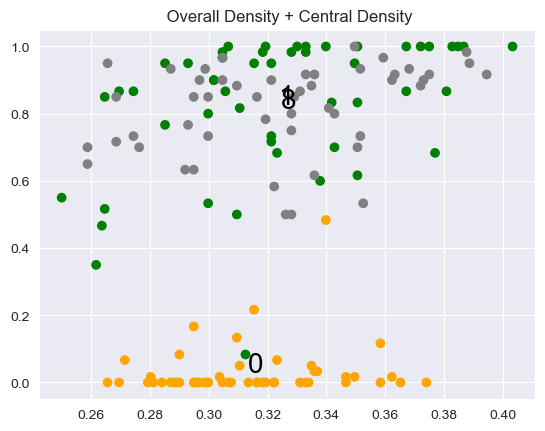

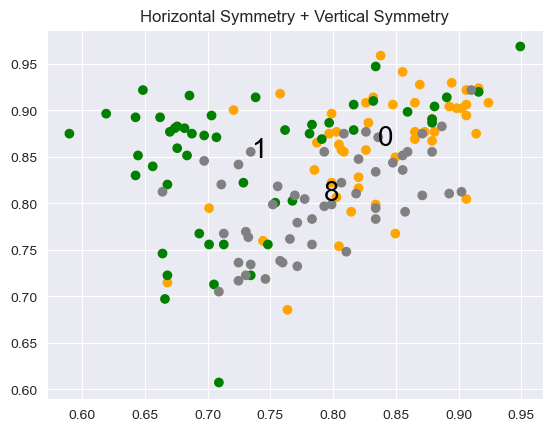

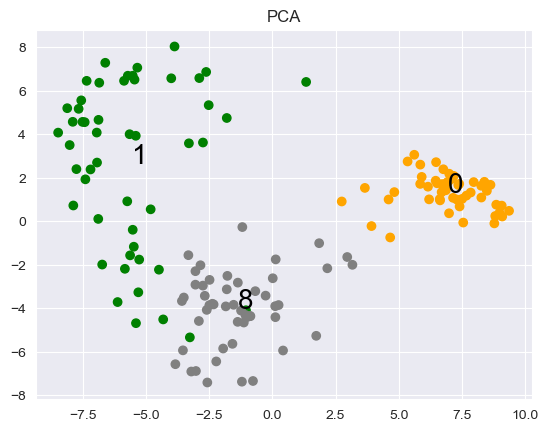

In [6]:
def plot_embedding(data, y, title):
  fig, ax = plt.subplots()
  colors = np.array(["orange", "green", "", "", "", "", "", "", "grey"])
  ax.scatter(data[:,0], data[:,1], c=colors[y])
  ys = np.unique(y)
  for target_y in ys:
    center = np.mean(data[y == target_y], axis=0)
    ax.text(center[0], center[1], f"{target_y}", c="black", size=20)
  plt.title(title)
  plt.show()
  
plot_embedding(density_data, y, " Overall Density + Central Density")
plot_embedding(symmetry_data, y, "Horizontal Symmetry + Vertical Symmetry")
plot_embedding(pca_data, y, "PCA")